<a href="https://colab.research.google.com/github/MaximL98/Manipulated-Reality/blob/master/video_analysis/colab_notebooks/video_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Capstone Project Part III**
***This Notebook is the third and final step, perfom model training.***

# Section I
Importing necessary libraries, connecting to Google Drive, setting hyperparameters and loading data.


In [2]:
# Install the newest keras version
!pip install --upgrade keras

In [3]:
# Import necessary libraries
import random
import keras
import numpy as np
import pandas as pd

In [4]:
keras.__version__

'3.4.1'

In [5]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Paths to csv's file that are located in the drive
paths_to_csv = {
    'train_df': '/content/drive/MyDrive/ManipulatedReality/NumpyConvertedDatabases/Celeb-DF-v2/train_df_full.csv',
    'test_df': '/content/drive/MyDrive/ManipulatedReality/NumpyConvertedDatabases/Celeb-DF-v2/test_df_full.csv',
    'val_df': '/content/drive/MyDrive/ManipulatedReality/NumpyConvertedDatabases/Celeb-DF-v2/val_df_full.csv'
}

path_prefix = '/content/drive/MyDrive/ManipulatedReality/NumpyConvertedDatabases'

In [ ]:
!ls /content/drive/MyDrive/ManipulatedReality/NumpyConvertedDatabases/Celeb-DF-v2

Celeb-real	       normalized_data_real   train_df_30fps.csv      val_df_30fps.csv.csv
Celeb-real-30fps       test_df_30fps.csv      train_df_30fps.csv.csv  val_df.csv
Celeb-synthesis        test_df_30fps.csv.csv  train_df_30fps.gsheet   val_df_full.csv
Celeb-synthesis-30fps  test_df.csv	      train_df.csv	      val_df.gsheet
feature_extracted      test_df_full.csv       train_df_full.csv
normalized_data_fake   tmp		      val_df_30fps.csv


In [7]:
# Hyperparameters
IMG_SIZE = 224
MAX_SEQ_LENGTH = 200
NUM_FEATURES = 2048

In [8]:
# Load dataframes, training testing and validation
train_df = pd.read_csv(paths_to_csv['train_df'])
test_df = pd.read_csv(paths_to_csv['test_df'])
val_df = pd.read_csv(paths_to_csv['val_df'])
print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")
print(f"Total videos for validation: {len(val_df)}")

train_df.sample(10)

Total videos for training: 8949
Total videos for testing: 3009
Total videos for validation: 3069


,video_path,label
1397,/content/drive/MyDrive/ManipulatedReality/Nump...,1
4483,/content/drive/MyDrive/ManipulatedReality/Nump...,1
8396,/content/drive/MyDrive/ManipulatedReality/Nump...,0
6119,/content/drive/MyDrive/ManipulatedReality/Nump...,0
5762,/content/drive/MyDrive/ManipulatedReality/Nump...,0
2913,/content/drive/MyDrive/ManipulatedReality/Nump...,1
2359,/content/drive/MyDrive/ManipulatedReality/Nump...,1
8657,/content/drive/MyDrive/ManipulatedReality/Nump...,0
7465,/content/drive/MyDrive/ManipulatedReality/Nump...,0
120,/content/drive/MyDrive/ManipulatedReality/Nump...,1


# Section II
Loading fine-tuned model, defining the feature extraction model, setting intermediate data saving checkpoints and running the feature extraction model on all training and validation videos.

In [ ]:
!ls /content/drive/MyDrive/ManipulatedReality/Fine-TunedModel

inceptionv3_tuned_model_full_20_07.h5	  inceptionv3_tuned_weights_full_20_07.h5
inceptionv3_tuned_model_full_22_07.h5	  inceptionv3_tuned_weights_full_22_07.weights.h5
inceptionv3_tuned_model_full_22_07.keras  inceptionv3_tuned_weights_full.h5
inceptionv3_tuned_model_full.h5		  inceptionv3_tuned_weights.h5
inceptionv3_tuned_model.h5		  inceptionv3_tuned_weights_test.h5
inceptionv3_tuned_model_test.h5


In [ ]:
# Load fine-tuned model from Google drive
from keras.models import load_model
path_to_model = '/content/drive/MyDrive/ManipulatedReality/Fine-TunedModel/inceptionv3_tuned_model_full_22_07.keras'
fine_tuned_model = load_model(path_to_model)
fine_tuned_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 26,001,188 (99.19 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 2,099,203 (8.01 MB)

In [ ]:
# Function that defines the feature extractor (CNN based) model
def build_feature_extractor():
    # Use the fine-tuned model as the base for the feature extractor
    feature_extractor = fine_tuned_model
    # Import the preprocessing function for InceptionV3
    preprocess_input = keras.applications.inception_v3.preprocess_input
    # Create an input layer for images with the specified size and channels
    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    # Preprocess the input images using the InceptionV3 preprocessing function
    preprocessed = preprocess_input(inputs)
    # Extract features from the preprocessed images using the fine-tuned model
    outputs = feature_extractor(preprocessed)
    # Create a Keras Model instance with the input and output layers
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()


In [ ]:
import time
import pickle

In [ ]:
def resume_from_checkpoint(pickle_save_path):
    with open(pickle_save_path, 'rb') as f:
        # Load the checkpoint data from the pickled file
        checkpoint = pickle.load(f)
    # Extract the required data from the checkpoint
    return checkpoint['idx'], checkpoint['frame_features'], checkpoint['labels']


In [ ]:
def prepare_all_videos(df, root_dir, save_interval, save_path):

    num_samples = len(df)
    video_paths = df["video_path"].values.tolist()
    labels = df["label"].values

    try:
      # Attempt to resume from a previous checkpoint
      start_idx, frame_features, labels = resume_from_checkpoint(save_path)
      print(f"Resuming from checkpoint ... ")
    except FileNotFoundError:
      # Start from scratch if no checkpoint found
      print(f"No checkpoint found ... ")
      start_idx = 0
      frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float16")


    # Process each video
    for idx, path in enumerate(video_paths):
        if idx < start_idx:
          # Skip videos already processed
          continue
        start_time = time.time()
        print(f"Video {idx + 1}/{len(video_paths)}")
        # Load video frames
        frames = np.load(path)
        frames = frames[None, ...] # Add batch dimension
        # Initialize an array to store extracted features
        temp_frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float16")

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)  # Limit the number of frames to MAX_SEQ_LENGTH
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :], verbose=0,)  # Extract features for each frame
            end_time = time.time()
            print(f"Extract features time: {end_time - start_time}")
        frame_features[idx,] = temp_frame_features.squeeze()  # Remove the batch dimension

        # Save intermediate results every 100 videos
        if (idx + 1) % save_interval == 0:
            print(f"Saving intermediate result ... ")
            checkpoint = {
                'idx': idx,
                'frame_features': frame_features,
                'labels': labels
            }
            with open(save_path, 'wb') as f:
                pickle.dump(checkpoint, f)

    return frame_features, labels



Saving into Google drive the feature extracted data

In [ ]:
print("Feature extracting: Train data ...")
pickle_save_path = path_prefix + '/Celeb-DF-v2/feature_extracted/prepare_all_videos_checkpoint.pkl'
train_data, train_labels = prepare_all_videos(train_df, "train", 100, pickle_save_path) # Save intermediate results every 100 videos

np.save(path_prefix + '/Celeb-DF-v2/feature_extracted/train_data_features_full.npy', train_data)
np.save(path_prefix + '/Celeb-DF-v2/feature_extracted/train_labels_full.npy', train_labels)

Feature extracting: Train data ...
Resuming from checkpoint ... 
Video 8900/8949
Extract features time: 32.87780022621155
Saving intermediate result ... 
Video 8901/8949
Extract features time: 14.639140129089355
Video 8902/8949
Extract features time: 16.28648567199707
Video 8903/8949
Extract features time: 16.88353443145752
Video 8904/8949
Extract features time: 16.07467555999756
Video 8905/8949
Extract features time: 16.838954210281372
Video 8906/8949
Extract features time: 16.28108787536621
Video 8907/8949
Extract features time: 12.204763174057007
Video 8908/8949
Extract features time: 14.846575498580933
Video 8909/8949
Extract features time: 15.453751802444458
Video 8910/8949
Extract features time: 13.416759967803955
Video 8911/8949
Extract features time: 12.304441213607788
Video 8912/8949
Extract features time: 6.365039587020874
Video 8913/8949
Extract features time: 12.632404565811157
Video 8914/8949
Extract features time: 12.36841630935669
Video 8915/8949
Extract features time: 1

In [ ]:
# Save intermediate results every 100 videos
print("Feature extracting: Test data ...")
pickle_save_path_test = path_prefix + '/Celeb-DF-v2/feature_extracted/prepare_all_videos_checkpoint_test.pkl'
test_data, test_labels = prepare_all_videos(test_df, "test", 100, pickle_save_path_test) # Save intermediate results every 100 videos

np.save(path_prefix + '/Celeb-DF-v2/feature_extracted/test_data_features_full.npy', test_data)
np.save(path_prefix + '/Celeb-DF-v2/feature_extracted/test_labels_full.npy', test_labels)

Streaming output truncated to the last 5000 lines.
Extract features time: 16.353853702545166
Video 523/3009
Extract features time: 15.546184301376343
Video 524/3009
Extract features time: 17.155120134353638
Video 525/3009
Extract features time: 16.773555278778076
Video 526/3009
Extract features time: 16.266143798828125
Video 527/3009
Extract features time: 15.468303203582764
Video 528/3009
Extract features time: 17.182568788528442
Video 529/3009
Extract features time: 16.362959623336792
Video 530/3009
Extract features time: 16.363497734069824
Video 531/3009
Extract features time: 18.415746927261353
Video 532/3009
Extract features time: 17.54117512702942
Video 533/3009
Extract features time: 17.33320951461792
Video 534/3009
Extract features time: 15.402477741241455
Video 535/3009
Extract features time: 17.4740629196167
Video 536/3009
Extract features time: 15.65127182006836
Video 537/3009
Extract features time: 16.952236652374268
Video 538/3009
Extract features time: 16.198949575424194


In [ ]:
# Save intermediate results every 100 videos
print("Feature extracting: Validation data ...")
pickle_save_path_val = path_prefix + '/Celeb-DF-v2/feature_extracted/prepare_all_videos_checkpoint_val.pkl'
val_data, val_labels = prepare_all_videos(val_df, "val", 100, pickle_save_path_val) # Save intermediate results every 100 videos

np.save(path_prefix + '/Celeb-DF-v2/feature_extracted/val_data_features_full.npy', val_data)
np.save(path_prefix + '/Celeb-DF-v2/feature_extracted/val_labels_full.npy', val_labels)

Feature extracting: Validation data ...
Resuming from checkpoint ... 
Video 2300/3069
Extract features time: 29.84811806678772
Saving intermediate result ... 
Video 2301/3069
Extract features time: 12.068772554397583
Video 2302/3069
Extract features time: 17.460265636444092
Video 2303/3069
Extract features time: 12.769729614257812
Video 2304/3069
Extract features time: 14.631145000457764
Video 2305/3069
Extract features time: 15.667807340621948
Video 2306/3069
Extract features time: 10.950254201889038
Video 2307/3069
Extract features time: 13.294503927230835
Video 2308/3069
Extract features time: 13.220913648605347
Video 2309/3069
Extract features time: 17.79903268814087
Video 2310/3069
Extract features time: 16.23866558074951
Video 2311/3069
Extract features time: 15.776841878890991
Video 2312/3069
Extract features time: 13.736279726028442
Video 2313/3069
Extract features time: 13.376924991607666
Video 2314/3069
Extract features time: 13.45085859298706
Video 2315/3069
Extract features

Loading from Google Colab the extracted data.

In [9]:
# Load the saved features and labels
train_features = np.load(path_prefix + '/Celeb-DF-v2/feature_extracted/train_data_features_full.npy')
train_labels = np.load(path_prefix + '/Celeb-DF-v2/feature_extracted/train_labels_full.npy')

test_features  = np.load(path_prefix + '/Celeb-DF-v2/feature_extracted/test_data_features_full.npy')
test_labels = np.load(path_prefix + '/Celeb-DF-v2/feature_extracted/test_labels_full.npy')

val_features = np.load(path_prefix + '/Celeb-DF-v2/feature_extracted/val_data_features_full.npy')
val_labels = np.load(path_prefix + '/Celeb-DF-v2/feature_extracted/val_labels_full.npy')



# Section III
Defining sequence model (LSTM) and training the model

In [10]:

def get_sequence_model():
    # Input layer for frame features
    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    # First LSTM layer with 32 units, preserving sequence information
    x = keras.layers.LSTM(32, return_sequences=True)(frame_features_input)
    # Normalize the output of the LSTM layer
    x = keras.layers.BatchNormalization()(x)
    # Second LSTM layer with 16 units, summarizing the sequence
    x = keras.layers.LSTM(16)(x)
    # Dropout layer to prevent overfitting
    x = keras.layers.Dropout(0.3)(x)
    # Dense layer with 8 units and ReLU activation, with L2 regularization
    x = keras.layers.Dense(8, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(x)
    # Output layer with sigmoid activation for binary classification
    output = keras.layers.Dense(1, activation="sigmoid")(x)

    # Create the model
    model = keras.Model(frame_features_input, output)

    # Compile the model with binary crossentropy loss, Adam optimizer, and accuracy, precision, and recall metrics
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=["accuracy", "precision", "recall"]
    )
    return model


In [12]:
def run_experiment():
    # Define the filepath to save the model weights
    filepath = path_prefix + "/tmp/video_classifier/ckpt.weights.h5"
    # Create a ModelCheckpoint callback
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, # Path to save weights
        save_weights_only=True, # Only save model weights, not entire model
        save_best_only=True, # Only save weights for the best performing epoch
        verbose=1 # Print information about saving weights
    )

    # Use early stopping to prevent overfitting
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=5 # Stop training if validation loss doesn't improve for 5 epochs
                                                   )
    # Get the pre-defined sequence model
    seq_model = get_sequence_model()

    # Train the model with callbacks
    history = seq_model.fit(
        train_features,
        train_labels,
        epochs=10,
        validation_data=(val_features, val_labels),
        callbacks=[checkpoint, early_stopping],
    )

    return history, seq_model

history, sequence_model = run_experiment()

Epoch 1/10
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7866 - loss: 0.6189 - precision: 0.8115 - recall: 0.8664
Epoch 1: val_loss improved from inf to 0.72456, saving model to /content/drive/MyDrive/ManipulatedReality/NumpyConvertedDatabases/tmp/video_classifier/ckpt.weights.h5
280/280 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - accuracy: 0.7868 - loss: 0.6185 - precision: 0.8116 - recall: 0.8667 - val_accuracy: 0.4783 - val_loss: 0.7246 - val_precision: 0.6687 - val_recall: 0.2923
Epoch 2/10
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8275 - loss: 0.4942 - precision: 0.8265 - recall: 0.9167
Epoch 2: val_loss improved from 0.72456 to 0.58434, saving model to /content/drive/MyDrive/ManipulatedReality/NumpyConvertedDatabases/tmp/video_classifier/ckpt.weights.h5
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.8275 - loss: 0.4942 - precision: 0.8265 - recall: 0.9167 - val_accuracy: 0.7709 - val_loss: 0.5843 - val_precision: 0.7596 - val_recall: 0.9153
Epoch 3/10
2

 Training loss and validation loss over epochs. This helps visualize how well the model is learning and identify potential overfitting.

# Section IV
From histroy ploting training process, later evaluating model performance.
Ploting confusion matrix, roc_curve and printing classification report.

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

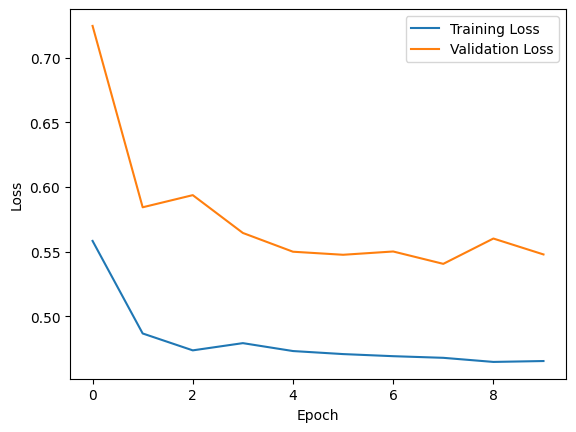

In [14]:
# Plot the training and validation loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
# Set labels for the axes
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# Display the plot
plt.show()

Training accuracy and validation accuracy over epochs. This shows how well the model is classifying correctly on both training and validation data.

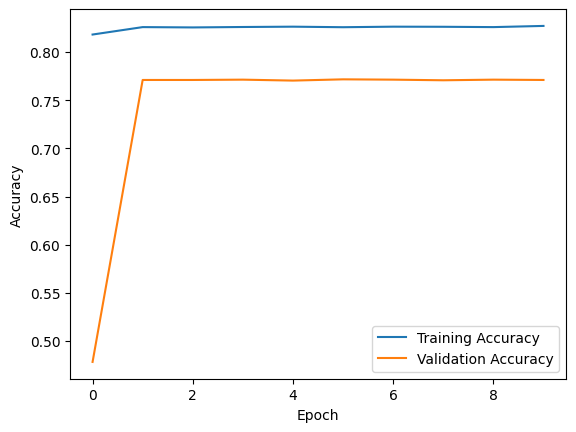

In [15]:
# Plot the training and validation accuracy curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# Set labels for the axes
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# Display the plot
plt.show()

In [16]:
# Define the file path where the model weights are saved
filepath = path_prefix + "/tmp/video_classifier/ckpt.weights.h5"

# Load the pre-trained weights into the sequence model
sequence_model.load_weights(filepath)

# Evaluate the model's performance on the test data
sequence_model.evaluate(test_features, test_labels)

95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8472 - loss: 0.4502 - precision: 0.9474 - recall: 0.8832


[0.5329744815826416, 0.7770023345947266, 0.7629629373550415, 0.932374894618988]

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

In [18]:
# Generate predictions on the test set
y_pred = sequence_model.predict(test_features)
threshold = 0.5
y_pred_classes = (y_pred >= threshold).astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred_classes)

95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


Plot the confusion matrix to visualize how many samples were classified correctly and incorrectly for each class (real vs. deepfake).
*   0 - Fake
*   1 - Real





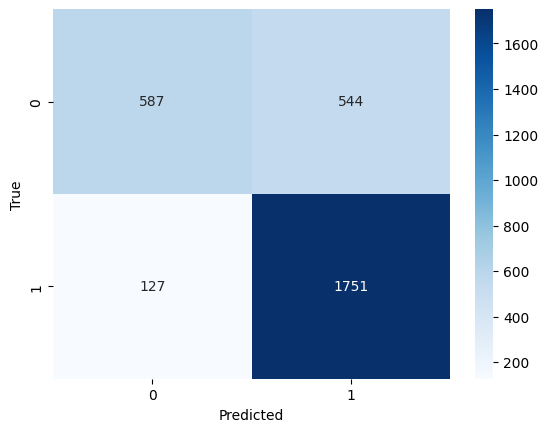

In [19]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Precision, recall, F1-score, and support for each class, giving a more comprehensive picture of model performance.
*   0 - Fake
*   1 - Real

In [20]:
print(classification_report(test_labels, y_pred_classes))

              precision    recall  f1-score   support

           0       0.82      0.52      0.64      1131
           1       0.76      0.93      0.84      1878

    accuracy                           0.78      3009
   macro avg       0.79      0.73      0.74      3009
weighted avg       0.79      0.78      0.76      3009



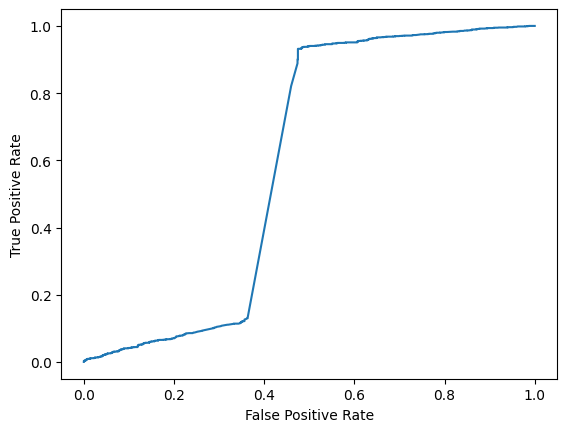

In [21]:
# Import libraries for calculating ROC curve and plotting
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import random

fpr, tpr, thresholds = roc_curve(test_labels, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [22]:
test_df_links = list(test_df['video_path'])

In [23]:
results = [] # Create an empty list to store the results
# Iterate over each data point in the test set
for i in range(len(test_features)):
    # Extract the link, true label, and predicted class for the current data point
    results.append((test_df_links[i], test_labels[i], y_pred_classes[i][0]))

In [24]:
random.shuffle(results)
for i in range(10):
    print(results[i])

('/content/drive/MyDrive/ManipulatedReality/NumpyConvertedDatabases/Celeb-DF-v2/Celeb-synthesis/test/id6_id4_0004_processed.npy', 0, 1)
('/content/drive/MyDrive/ManipulatedReality/NumpyConvertedDatabases/Celeb-DF-v2/Celeb-synthesis/test/id20_id3_0000_processed.npy', 0, 0)
('/content/drive/MyDrive/ManipulatedReality/NumpyConvertedDatabases/Celeb-DF-v2/Celeb-synthesis/test/id23_id37_0001_processed.npy', 0, 0)
('/content/drive/MyDrive/ManipulatedReality/NumpyConvertedDatabases/Celeb-DF-v2/Celeb-synthesis/test/id29_id37_0005_processed.npy', 0, 1)
('/content/drive/MyDrive/ManipulatedReality/NumpyConvertedDatabases/Celeb-DF-v2/Celeb-real/test/id10596#TTPPaLjZMCU#003944#004183_processed.npy', 1, 1)
('/content/drive/MyDrive/ManipulatedReality/NumpyConvertedDatabases/Celeb-DF-v2/Celeb-real/test/00129_processed.npy', 1, 1)
('/content/drive/MyDrive/ManipulatedReality/NumpyConvertedDatabases/Celeb-DF-v2/Celeb-real/test/id10001#J9lHsKG98U8#004746#004904_processed.npy', 1, 1)
('/content/drive/MyDriv